# Devide image and finetune vgg16 

## Import modules

In [1]:
import os
import math
import glob
import random
import datetime
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter, map_coordinates

## Define global constants

In [2]:
image_dir = '../datasets/pathologocal_images_JPEG'
label_dir = '../datasets/ndarray_labels'
image_ext = '.jpg'
label_ext = '.npy'
num_partitions_on_each_site = 4
connection_symbol = '^'
model_input_shape = np.array([128, 128, 3])
batch_size = 32
random_seed = 0
validation_ratio = 0.2
num_epochs = 20

## Load sample name list

In [3]:
train_val_sample_names_path = '../datasets/train_val.txt'
test_sample_names_path = '../datasets/test.txt'
train_val_sample_names_file = open(train_val_sample_names_path)
train_val_sample_names = train_val_sample_names_file.read().splitlines()
test_sample_names_file = open(test_sample_names_path)
test_sample_names = test_sample_names_file.read().splitlines()

## Split sample names into training sample names and validation sample names

In [4]:
training_sample_names, validation_sample_names = train_test_split(
    train_val_sample_names,
    test_size=validation_ratio,
    random_state=random_seed
)

## Add suffix that represent position of partition to sample name

In [5]:
training_sample_name_with_partition_indices = []
for sample_name in training_sample_names[:10]:
    training_sample_name_with_partition_indices += list(itertools.chain.from_iterable([[sample_name+connection_symbol+str(i)+connection_symbol+str(j) for j in range(num_partitions_on_each_site)] for i in range(num_partitions_on_each_site)]))
training_sample_name_with_partition_indices

validation_sample_name_with_partition_indices = []
for sample_name in validation_sample_names[:4]:
    validation_sample_name_with_partition_indices += list(itertools.chain.from_iterable([[sample_name+connection_symbol+str(i)+connection_symbol+str(j) for j in range(num_partitions_on_each_site)] for i in range(num_partitions_on_each_site)]))

test_sample_name_with_partition_indices = []
for sample_name in validation_sample_names[:4]:
    test_sample_name_with_partition_indices += list(itertools.chain.from_iterable([[sample_name+connection_symbol+str(i)+connection_symbol+str(j) for j in range(num_partitions_on_each_site)] for i in range(num_partitions_on_each_site)]))
    
print(len(training_sample_name_with_partition_indices), len(validation_sample_name_with_partition_indices), len(test_sample_name_with_partition_indices))


160 64 64


## Create pipelines

### Define function to preprocess data

sample name -> 017-0860_7_T_mimura_633^0^0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


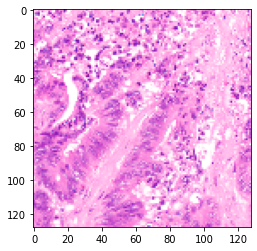

label -> 1


In [6]:
def load_label_array(array_path_tensor):
    array_path = array_path_tensor.numpy()
    label_array = np.load(array_path)
    return label_array

def split_string(string_tensor):
    string = string_tensor.numpy()
    string.split(connection_symbol)
    return ['1','1','1']

def load_and_preprocess_image(sample_name_with_partition_indices):
    sample_name = tf.strings.split(sample_name_with_partition_indices, connection_symbol)[0]
    row_index = tf.strings.split(sample_name_with_partition_indices, connection_symbol)[1]
    column_index = tf.strings.split(sample_name_with_partition_indices, connection_symbol)[2]
    row_index = int(row_index)
    column_index = int(column_index)
    brightness_max_delta = 0.1
    image_path = image_dir + '/' + sample_name + image_ext
    raw_image = tf.io.read_file(image_path)
    image_tensor = tf.image.decode_jpeg(raw_image)
    image_tensor = tf.image.resize(image_tensor, num_partitions_on_each_site*model_input_shape[:2])
    image_tensor = image_tensor[
        row_index*model_input_shape[0]:(row_index+1)*model_input_shape[0],
        column_index*model_input_shape[1]:(column_index+1)*model_input_shape[1],
        :
    ]
    image_tensor /= 255.0
    image_tensor = tf.image.random_flip_left_right(image_tensor, seed=None)
    image_tensor = tf.image.random_flip_up_down(image_tensor, seed=None)
    image_tensor = tf.image.random_brightness(image_tensor, brightness_max_delta)
    label_array_path = label_dir + '/' + sample_name + label_ext
    label_tensor = tf.py_function(func=load_label_array, inp=[label_array_path], Tout=tf.uint8)
    label_tensor = label_tensor[ ..., tf.newaxis]
    label_tensor.set_shape([630,630,1])
    label_tensor = tf.image.resize(label_tensor, num_partitions_on_each_site*model_input_shape[:2])[...,0]
    label_tensor = tf.slice(
        label_tensor, 
        [row_index*model_input_shape[0], column_index*model_input_shape[1]], 
        model_input_shape[:2]
    )
    label = tf.cast(tf.math.reduce_sum(tf.cast(label_tensor==2, tf.int32))>0, tf.int32)
    return image_tensor, label

sample_name_with_partition_index = training_sample_name_with_partition_indices[0]
print('sample name -> {}'.format(sample_name_with_partition_index))
preprocessed_image_tensor, label = load_and_preprocess_image(sample_name_with_partition_index)
plt.imshow(preprocessed_image_tensor)
plt.show()
print('label -> {}'.format(label))

### Create training pipeline

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
num_training_samples = len(training_sample_name_with_partition_indices)
training_sample_name_dataset = tf.data.Dataset.from_tensor_slices(training_sample_name_with_partition_indices)
training_pipeline = (
    training_sample_name_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
        .cache()
        .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=num_training_samples))
        .batch(batch_size)
        .prefetch(buffer_size=AUTOTUNE)
)
training_steps_per_epoch=tf.math.ceil(num_training_samples/batch_size).numpy()

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


### Create validation pipeline

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
num_validation_samples = len(validation_sample_name_with_partition_indices)
validation_sample_name_dataset = tf.data.Dataset.from_tensor_slices(validation_sample_name_with_partition_indices)
validation_pipeline = (
    validation_sample_name_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
        .cache()
        .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=num_validation_samples))
        .batch(batch_size)
        .prefetch(buffer_size=AUTOTUNE)
)
validation_steps_per_epoch=tf.math.ceil(num_validation_samples/batch_size).numpy()

### Create test pipeline

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
num_test_samples = len(test_sample_name_with_partition_indices)
test_sample_name_dataset = tf.data.Dataset.from_tensor_slices(test_sample_name_with_partition_indices)
test_pipeline = (
    test_sample_name_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
        .cache()
        .batch(batch_size)
        .prefetch(buffer_size=AUTOTUNE)
)

## Create model

In [10]:
input_tensor = tf.keras.Input(shape=model_input_shape)
vgg16 =  tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
x = vgg16.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=vgg16.input, outputs=x)

# model.summary()

## Compile model

In [11]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
)
loss_fn = tf.keras.losses.BinaryCrossentropy()
model.compile(
    loss=loss_fn,
    optimizer=optimizer,
    metrics=['accuracy']
)

## Define callbacks

In [12]:
result_save_dir = './results'
if not os.path.exists(result_save_dir):
    os.mkdir(result_save_dir)
    
current_time = datetime.datetime.now().isoformat()
current_result_save_dir = './results/{}'.format(current_time)
if not os.path.exists(current_result_save_dir):
    os.mkdir(current_result_save_dir)


def schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(
    schedule=schedule, 
    verbose=1
)
csv_logging_path = os.path.join(current_result_save_dir,'training.log')
csv_logger = tf.keras.callbacks.CSVLogger(csv_logging_path)
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=0.000001,
    verbose=1
)
checkpoint_filepath = os.path.join(current_result_save_dir,'model_{val_loss}_{val_accuracy}.h5')
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks = [
    learning_rate_scheduler,
    csv_logger,
    reduce_lr_on_plateau,
    model_checkpoint,
]

## Train model

In [13]:
history = model.fit(
    training_pipeline, 
    epochs=num_epochs, 
    steps_per_epoch=training_steps_per_epoch, 
    validation_data=validation_pipeline, 
    validation_steps=validation_steps_per_epoch,
    callbacks=callbacks
)


Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 1/20
5/5 [==============================] - 37s 7s/step - loss: 0.6915 - accuracy: 0.5562 - val_loss: 0.9518 - val_accuracy: 0.2500

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 2/20
5/5 [==============================] - 18s 4s/step - loss: 0.6095 - accuracy: 0.6812 - val_loss: 0.8891 - val_accuracy: 0.2500

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 3/20
5/5 [==============================] - 18s 4s/step - loss: 0.5042 - accuracy: 0.7375 - val_loss: 0.6706 - val_accuracy: 0.5312

Epoch 00004: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 4/20
5/5 [==============================] - 18s 4s/step - loss: 0.4303 - accuracy: 0.8062 - val_loss: 0.6856 - val_accuracy: 0.4531

Epoch 00005: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 5/20
5/5 [=======

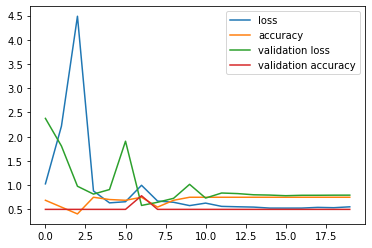

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.legend(['loss', 'accuracy', 'validation loss', 'validation accuracy'])

## Evaluate model with test samples

13/13 [==============================] - 1s 109ms/step - loss: 0.1836 - accuracy: 0.9704
test_resluts -> [0.18363627791404724, 0.9704433679580688]


,Normal,Tumor
Normal,112,2
Tumor,4,85


Text(33.0, 0.5, 'True')

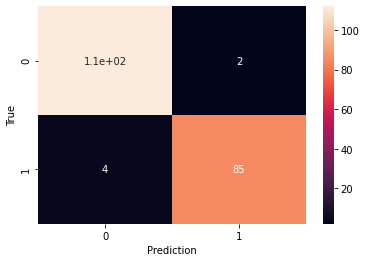

In [112]:
test_resluts = model.evaluate(test_pipeline)
print('test_resluts -> {}'.format(test_resluts))
test_predictions = model.predict(test_pipeline)[:,0]>0.5
test_true_labels = []
for image, label in test_pipeline:
    test_true_labels += [*label.numpy()]
label_dict = {0: 'Normal', 1: 'Tumor'}
test_confusion_matrix = confusion_matrix(
    [to_label[label] for label in true_labels], 
    [to_label[label] for label in test_predictions]
)
test_confusion_matrix_df = pd.DataFrame(
    test_confusion_matrix, sssss1
    columns=list(label_dict.values()), 
    index=list(label_dict.values())
)
display(test_confusion_matrix_df)
sns.heatmap(test_confusion_matrix, annot=True)
plt.xlabel('Prediction')
plt.ylabel('True')